Nozomu Nakanishi - 2020264 - Msc DA

This notebook presents the technical part of the research which aims develop a neural network for sentiment analysis. The chosen networks <b>is/are, LSTM and (if you have time to develop a different one.</b>
The chronological order will follow: 
1. Introduction;
2. Data preparation and EDA; 
3. Text pre-processing;
4. Embedding and Padding; 
5. LSTM; 
. Conclusion 

## 1. Introduction 

The experiment will be carried out by importing the chosen dataset from Kaggle, the data is licensed under the Creative Commons (CC0 1.0 DEED), allowing the use of the data. 

The link for the dataset is available at kaggle: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews

The objective of the notebook is to develop a neural network using PySpark (chosen tool for the project) and the chosen dataset to achieve the goal is the recipe reviews from food.com, which is  composed by 8 features and more tham a million rows.
- There are two datasets in the zip file, however it does not says that the recipe ID in one will match the recipe ID in the other, therefore using only the reviews dataset.
- Also, two types of format is available, parquet and csv files. And the choice for the first one is that the parquet file already has a columnar type, which when taking into consideration the tools that are being used such as pyspark it will present a better speed perfomance when performing tasks. In addition to the reduction for its size in megabytes (csv - 496.1 and 173.8). 
- The dataset review, which is going to be manipulated, is about the written reviews along with score rating given. They are the most important features in the dataset to achieve the objective. 

<b>The technical part of the task will be carried out by performing sentiment analysis using Long Short Term Memory (LSTM).....</b>

In [1]:
# The command below is to check where the PySpark is running, 
# in this case (returned:local[*]) data is being processed on my local (personal) machine.

sc.master

'local[*]'

- The libraries to perform the required stages are going to be imported in the next cell.

In [2]:
from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.functions import explode, desc # Importing for word count.
from pyspark.ml.feature import StopWordsRemover # Imports stopword remover.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import Word2Vec
import numpy as np # for numerical operations.
import seaborn as sns # Visualization tool.
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import spacy

import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Initiating a spark session.
spark = SparkSession.builder.appName('recipe_reviews').getOrCreate()

## 2. Data preparation and EDA
- Challeging to separete them both because it will be performed back and forth.
- First, the numerical feature will be analysed and after the written review. 

#### - Importing the Review dataset.

To start the dataset will be imported in parquet format as cited in the introduction.

In [4]:
# Imports the dataset in a parquet format.
df_reviews_og = spark.read.parquet("file:///home/hduser/Downloads/Dataset CA1/reviews.parquet")

In [5]:
# Prints the Schema of the dataset.
df_reviews_og.printSchema()

root
 |-- ReviewId: integer (nullable = true)
 |-- RecipeId: integer (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Review: string (nullable = true)
 |-- DateSubmitted: timestamp (nullable = true)
 |-- DateModified: timestamp (nullable = true)



- The parquet format file already had a schema, therefore keeping the original dataset schema. However, if the csv were to be handled the following code would be appropriate to apply the schema, including the column names along with the data type.

In [6]:
# Code that would be used to apply the schema in the review dataset if was required.

#schema_reviews = StructType([
    #StructField('ReviewId', IntegerType(), True),
    #StructField('RecipeId', IntegerType(), True),
    #StructField('AuthorId', IntegerType(), True),
    #StructField('AuthorName', StringType(), True),
    #StructField('Rating', IntegerType(), True),
    #StructField('Review', StringType(), True),
    #StructField('DateSubmitted', TimestampType(), True),
    #StructField('DateModified', TimestampType(), True)])

The library Pandas used in the previous semester had different set of functions and/or commands. For example, the shape which provided the number of columns and observations in the dataset. However, in the PySpark the count method is use to tell how many rows and the lenght of the columns for the number of features. 
<br>However, in a later stage pandas format will be used for visualization purpose only, because pandas visualizations are better than the pyspark.

In [7]:
# It shows the first ten observations.
df_reviews_og.show(10)

+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|ReviewId|RecipeId|AuthorId|      AuthorName|Rating|              Review|      DateSubmitted|       DateModified|
+--------+--------+--------+----------------+------+--------------------+-------------------+-------------------+
|       2|     992|    2008|       gayg msft|     5|better than any y...|2000-01-25 21:44:00|2000-01-25 21:44:00|
|       7|    4384|    1634|   Bill Hilbrich|     4|I cut back on the...|2001-10-17 17:49:59|2001-10-17 17:49:59|
|       9|    4523|    2046|Gay Gilmore ckpt|     2|i think i did som...|2000-02-25 09:00:00|2000-02-25 09:00:00|
|      13|    7435|    1773|   Malarkey Test|     5|easily the best i...|2000-03-13 21:15:00|2000-03-13 21:15:00|
|      14|      44|    2085|      Tony Small|     5|  An excellent dish.|2000-03-28 13:51:00|2000-03-28 13:51:00|
|      17|    5221|    2046|Gay Gilmore ckpt|     4|love it, but with...|2000-05-08 12:0

In [8]:
num_rows_reviews = df_reviews_og.count() # Counting the number of rows.
num_columns_reviews =len(df_reviews_og.columns) # Length of columns.
print(f"Shape: ({num_rows_reviews}, {num_columns_reviews})") # Prints the shape of the dataset.

Shape: (1401982, 8)


The previous code shows the shape of the dataset (1401982 rows, 8 columns) and by looking at the features, a few of them will not be needed to the analysis.
- Temporal analysis is not the focus of the project, therefore, the date submitted and modified will be dropped in an early stage.
- The Ids will not be part of the model, but will remain to check if they can indicate any anomaly.  

In [9]:
# Droping two columns of the dataset.
df_reviews_og = df_reviews_og.drop("DateSubmitted", "DateModified")

In [10]:
# The two codes below are searching and printing the number of missing values in Review, Rating, Recipe Id.

missing_review = df_reviews_og.filter(df_reviews_og.Review.isNull())
print(f"Number of observations with missing Review: {missing_review.count()}")

missing_rating = df_reviews_og.filter(df_reviews_og.Rating.isNull())
print(f"Number of observations with missing Rating: {missing_rating.count()}")

Number of observations with missing Review: 0
Number of observations with missing Rating: 0


- No missing values are recorded in Review and Ratings. Only performing the command for two features because they are going to be the focus of the analysis. 

<br>

- The following codes does not affect the analysis directly, but it increases the knowledge about the data.
The next code will generate the frequency of three features, the Rating scores (check which score have the highest number and the lowest), the RecipeId (check how many times that recipe recieved a review and the AuthorId (check how many times that author wrote a review).

In [11]:
# The codes below are getting the frequency of values using the count function and printing them from
# the highest to the lowest.

df_reviews_og.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

df_reviews_og.groupBy("RecipeId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of RecipesId")

df_reviews_og.groupBy("AuthorId").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of AuthorId")

+------+-------+
|Rating|  count|
+------+-------+
|     0|  76248|
|     1|  16559|
|     2|  17597|
|     3|  50279|
|     4| 229217|
|     5|1012082|
+------+-------+

Frequency of Ratings


+--------+-----+
|RecipeId|count|
+--------+-----+
|   45809| 2892|
|    2886| 2182|
|   27208| 1614|
|   89204| 1584|
|   39087| 1491|
|   67256| 1359|
|   35813| 1353|
|   54257| 1325|
|   22782| 1273|
|   32204| 1228|
|  420398| 1174|
|   25690| 1076|
|   69173| 1023|
|   73440| 1008|
|   68955|  910|
|   33919|  885|
|   82102|  862|
|   25885|  856|
|   85629|  805|
|   28148|  804|
+--------+-----+
only showing top 20 rows

Frequency of RecipesId


+--------+-----+
|AuthorId|count|
+--------+-----+
|  424680| 8842|
|   37449| 6605|
|  383346| 5438|
|  128473| 4693|
|  169430| 4586|
|   89831| 3963|
|   58104| 3743|
|  199848| 3688|
|  133174| 3590|
|  305531| 3543|
|  226863| 3340|
|    4470| 3260|
|  369715| 3167|
|  498271| 3014|
| 1072593| 2810|
|  176615| 2790|
|   95743| 2664|
|  286566| 2635|
|  107583| 2588|
|   88099| 2574|
+--------+-----+
only showing top 20 rows

Frequency of AuthorId


- The Rating columns shows that most of its values are located between 4 and 5.

The Recipes and AuthorId column:
- The recipes that received the highest amount of reviews was with the ID of 45089 and 2886 (more than 2000 ratings);
- The Author that most reviewed recipes on the website was the Id 424680 with 8842, followed by Id 37449 with 6605 reviews;

The first attempt was with the entire dataset (1401982 observations), however due to computational reasons only 20% of the dataset will be manipulated and applied to the neural networks. 
- During the first attempt, any errors, typos in the parameters were taking hours to restart, or to wait for the error so it can be fixed later.

By looking at the rating score frequency in the previous code it is noticeable that distributions of the ratings are imbalanced. Thus, the 20% of the dataset will have the same imbalaced characteristics as the original dataset in order to maintain the shape of the data.
- Because tis experimentation is more focused on sentiment analysis, instead of sampling by the raw scores, the sentiment label (classes) will be used to applied a stratified split, maintaining the same distribution of classes as the original. 

In [12]:
# Creates a new column 'label' based on rating values
df_reviews_og = df_reviews_og.withColumn("label", 
                   when(col("rating").isin([0, 1, 2]), "negative")
                   .when(col("rating") == 3, "neutral")
                   .otherwise("positive")
                  )

# You can verify by showing a few records
df_reviews_og.select("rating", "label").show()

+------+--------+
|rating|   label|
+------+--------+
|     5|positive|
|     4|positive|
|     2|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     0|negative|
|     5|positive|
|     5|positive|
|     4|positive|
|     5|positive|
|     5|positive|
|     1|negative|
|     5|positive|
|     4|positive|
|     1|negative|
|     5|positive|
|     5|positive|
|     3| neutral|
+------+--------+
only showing top 20 rows



In [13]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Placing the 0,1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_reviews_og.withColumn(
    "Rating_class",
    when((df_reviews_og['Rating'] >= 0) & (df_reviews_og['Rating'] <= 2), "Negatives (0-2)")
    .when(df_reviews_og['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.586280%
Rating Class Negatives (0-2): 7.874851%
Rating Class Positives (4-5): 88.538869%


In [14]:
# Calculates the fraction for each label to reduce the dataset by half
# As mentioned previously the reduction is 50%.
fraction = 0.2
reduce_fractions = {label: fraction for label in df_reviews_og.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Reducing the dataset by half
df_reviews = df_reviews_og.sampleBy("label", fractions=reduce_fractions, seed=42)


In [15]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Placing the 0,1,2 to the negatives, 3 neutral and 4,5 positives.
class_counts = (
    df_reviews.withColumn(
    "Rating_class",
    when((df_reviews['Rating'] >= 0) & (df_reviews['Rating'] <= 2), "Negatives (0-2)")
    .when(df_reviews['Rating'] == 3, "Neutral (3)")
    .otherwise("Positives (4-5)"))
# Grouping the ratings into its class and using rdd to transform them into a dictionary which is easier to access in a query.
    .groupBy("Rating_class")
    .count()
    .rdd.collectAsMap())

# Calculates to total number of reviews.
total_reviews = sum(class_counts.values())
# Calculates the ratio.
Ratios = {k: v / total_reviews for k, v in class_counts.items()}
# Prints the percentages.
for Rating_class, ratio in Ratios.items():
    print(f"Rating Class {Rating_class}: {ratio*100:2f}%")

Rating Class Neutral (3): 3.604834%
Rating Class Negatives (0-2): 7.838451%
Rating Class Positives (4-5): 88.556715%


- After applying the stratfied split, the results were successful, the difference between before and after are less than decimals.

Thus, for the analysis the dataset to be handle is the half of the original named df_reviews.

In [16]:
# Displaying statistical features of the Reviews dataset.
df_reviews.describe().select("summary", "Rating").show()

+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|            281178|
|   mean|4.4086094929190764|
| stddev|1.2705678662629132|
|    min|                 0|
|    max|                 5|
+-------+------------------+



In [17]:
df_reviews.groupBy("Rating").count().orderBy("Rating").show()
print(f"Frequency of Ratings")

+------+------+
|Rating| count|
+------+------+
|     0| 15263|
|     1|  3296|
|     2|  3481|
|     3| 10136|
|     4| 46072|
|     5|202930|
+------+------+

Frequency of Ratings


Based on statistical feature:
- It has a range of scores between 0 and 5;
- The mean of 4.4 is close to 5, therefore most of the data points are close the highest value, so the data present signs of being left-skewed (strong evidence for skewness);
- Also, because most of the values a concentrated in the score 5, the box (boxplot) might be very close or at the top at the upper whisker.
- It presents a high standard deviation given the range of the scores.
- The score zero represents the majority in the negative class, while in the positive side the maximum value is more frequent also represents more than 50% of the data.

Further analysis will be performed using visual tools.

### Ratings feature visual representation.

- The visualization tools using Pandas provided a better result, therefore for visualization (boxplot and histogram) purpose it will be created a dataframe using pandas library.

In [18]:
# Creating a dataframe using pandas library.
ratings_column_pd = df_reviews.select("Rating").toPandas()

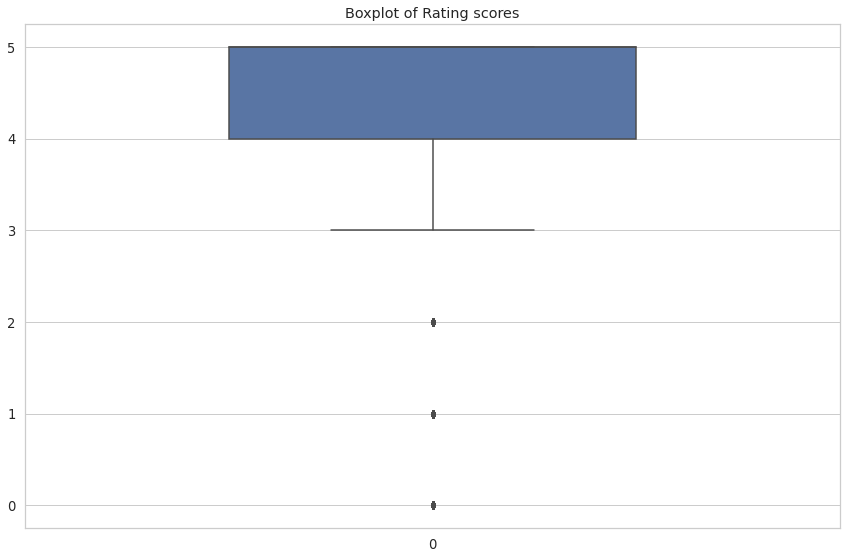

In [19]:
# Generating the figure.
plt.figure(figsize=(12, 8)) # Setting the figure size.
sns.set(style="whitegrid", font_scale=1.2) # Addind a white space on the back and adjustive font scale.
# Creates the boxplot
ax = sns.boxplot(data=ratings_column_pd['Rating'], width=0.5) # Boxplot, setting the width of the box to .5.
ax.set_title('Boxplot of Rating scores') # Add title to the figure.
plt.tight_layout() # Adjusts the layout
plt.show() # Shows the plot

The boxplot shows shows that most of values are located in the maximum values, but also points the score 0, 1 and 2 as outliers, this could be due to the fact that those values represents a small percentage of the total (approximately 7-8%). So based on IQR calculations are considering them as outliers.

- The values 1 and 2 will not be outliers, despite being a small amount they represent negative score reviews of the recipe;
- The value of 0 will be analysed in a later stage along with the writen review.

Despite considering of 1 and 2 score rating outliers, they will remain in the dataset. This is because they are still a valid data point and very important to achieve the goal. Although, the score zeros will be further analysed.

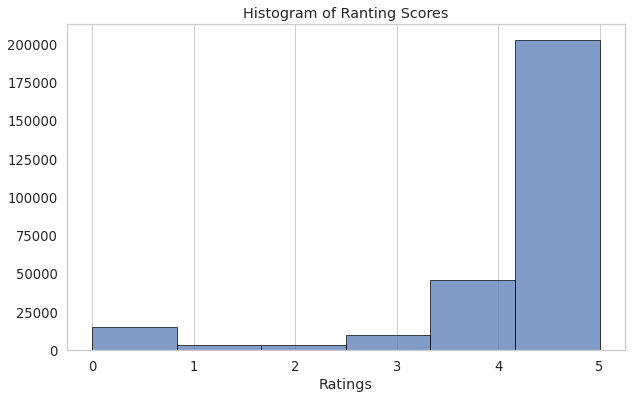

In [20]:
# Creating the figure for the histogram.
plt.figure(figsize=(10, 6))
# Plots the histogram, bins set at 6 because of the range of the value.
plt.hist(ratings_column_pd['Rating'], bins=6, edgecolor='black', alpha=0.7)
plt.title("Histogram of Ranting Scores") # Sets title.
plt.xlabel("Ratings") # Sets x label.
plt.xticks(range(6)) # Add ticks with range between 0 and 6.
plt.grid(axis='y') 
plt.show() # Display the histogram.

An extra visualization to look at the distribution of the data, the histogram shows that the ratings scores data is highly skewed to the left and most of its values are located at the maximum score.

The scores zero raised doubts about its reliability, potentially someone forgot to leave a score or if it is actually the worst score. Also, there are no notes about the score zero, so a manual check will be applied to check if there is a balance between the review and the score zero. The procedure will be done by looking at random samples (attempted multiple times with differend seed values), checking if the reviews truly represents a sentiment of a lowest score possible.

In [21]:
zero_reviews = df_reviews.filter(col("Rating") == 0)
sample_reviews = zero_reviews.sample(withReplacement=False, fraction=0.25, seed=36)
sample_reviews.select("Review").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review                                                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

- According to last code (with many attempts using different seed numbers), the written reviews does not match the score zero given. Positives reviews such as, great recipe, its delicious . Therefore, the chosen option is to drop the 0 scores (anomalies), so it does not affects the analysis by introducing noise to it, increasing the consistency in the data.
- And since they are anomalies in the data, the rows with score of 0 will be dropped.
<br><br><br>The next two codes will be used to drop (by using the method filter) and after printing the counts before and after the operation to check if it was correct. 

In [22]:
# Method filter to exclude the rows with Rating equal to zero.
df_reviews_no_zero = df_reviews.filter(df_reviews.Rating != 0)

In [23]:
# Counting observations before and after the exclusion and printing them for verification. 
original_count = df_reviews.count()
filtered_count = df_reviews_no_zero.count()
print(f"Original obs count: {original_count}")
print(f"After filter obs count: {filtered_count}")

Original obs count: 281178
After filter obs count: 265915


- After the drop, the observations reduced by 15263, which is the number of zero scores given (also provided at the frequency line of code). Therefore, the drop operation was sucessful.

## 3. Text pre-processing

Next stage will be the text processing of the Review column, however only a few steps of the pre processing will be called before splitting the dataset to avoid data leakage. And the steps before dividing into traininig, validation and test are:

- Lowering case; 
- Removing punctuations and \r\n;

In [24]:
# Creating a column named Review_lower to the dataframe in a lowercase version.
process_reviews = df_reviews_no_zero.withColumn("Review_lower", lower(col("Review")))

In [25]:
# Looks for any observation that the transformation did not work.
no_match = process_reviews.filter(lower(col("Review")) !=col("Review_lower")).count()

if no_match == 0:
    print("Transformation successful.")
else:
    print("There is/are rows that the transformation did not work.")

Transformation successful.


- After the transformation, a few statistical features will be generated before further processing for comparison purpose. 

In [26]:
# It sums the number of words in the review column.
w_count = process_reviews.withColumn("word_count", size(split(process_reviews["Review_lower"], " ")))
# Display statistical features of the review number of words.
w_count.select("word_count").describe().show()

+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|            265915|
|   mean|53.330346163247654|
| stddev| 37.51754164867301|
|    min|                 1|
|    max|               944|
+-------+------------------+



According to the descriptive statistics of the review (265915 in total):
- It ranges from 1 word to 944 words;
- The mean is 53.35, thus the average of words is 53 words per review.
- Most of the reviews are likely to be clustered in the lower values. 

In [27]:
# Displaying the characters length of the review_lowercase column
process_reviews = process_reviews.withColumn("rev_char_length", length(process_reviews["Review_lower"]))
# Displaying statistical feature of the reviews character length. 
process_reviews.select("rev_char_length").describe().show()

+-------+------------------+
|summary|   rev_char_length|
+-------+------------------+
|  count|            265915|
|   mean| 276.7425117048681|
| stddev|194.33281332072357|
|    min|                 0|
|    max|              5196|
+-------+------------------+



At this stage, the review features has:
- An average of 276 characters per review;
- Reviews range from 0 (empty) to 5196 (longest reviews);

Based on the values, the mean is much closer to the minimum than to the maximum value, therefore indicating that the distribution of the character length is right skewed. However, the histogram will be generate to be certain.

In [28]:
# Transforming to pandas dataframe for visualization purpose.
review_char_lengh_pd = process_reviews.select("rev_char_length").toPandas()

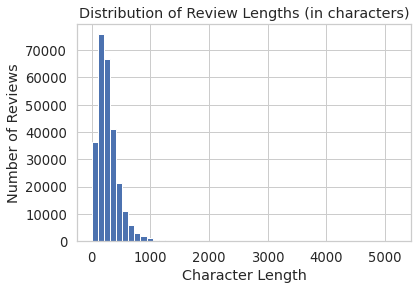

In [29]:
# Creating histogram for characters length
char_lengths = review_char_lengh_pd["rev_char_length"] # Data
char_lengths.hist(bins=50) # Generate histogram.
plt.xlabel("Character Length") # Adds label.
plt.ylabel("Number of Reviews") # Adds label.
plt.title("Distribution of Review Lengths (in characters)") # Adds title.
plt.show() # Shows the histogram.

- The histogram confirms what the descriptive statistic showed, that the distribution for the number of characters is right-skewed. 

In [30]:
# Group by the label column to get counts
class_counts = process_reviews.groupBy("label").count().rdd.collectAsMap()

# Calculate the total number of reviews
total_reviews = sum(class_counts.values())

# Calculate the ratios
Ratios = {k: v / total_reviews for k, v in class_counts.items()}

# Print the percentages
for label, ratio in Ratios.items():
    print(f"Rating Class {label.capitalize()}: {ratio*100:.2f}%")


Rating Class Positive: 93.64%
Rating Class Neutral: 3.81%
Rating Class Negative: 2.55%


The reviews have gone through some manipulation and the last line of code still shows that.

- By far, the highest number of score given is between the value of 4 and 5;
- Lower scores (1 , 2) represents less than 3% of the total of ratings given and less than 4% for neutral scores (3); <b> (Important rationale to balance the data in a later stage)</b>
- The imbalance between the positive classes are enourmous considering the others, and this potenlially could add bias into the sentiment analysis. To mitigate this issue there are some options available which will be attempt in a later stage. 
<br>
However, the ratio between the classes have changed:
- The positive class increased from 88.54 to 93.64;
- The neutral class increased from 3.59 to 3.81;
- The negative class decreased from 7.86 to 2.55%
Increasing even more the imbalance of the classes. Next pre processing stage is to remove punctuations and characters such as \r\n.

In [31]:
# Removing punctions of the Review_lowercase column.
process_reviews = process_reviews.withColumn("Review_no_punct", regexp_replace(col("Review_lower"), "[^a-zA-Z\s]", ""))

In [32]:
# Displays the rows of column before and after the removal of punctuations. 
process_reviews.select("Review_lower", "Review_no_punct").show(n=20, truncate=False)   

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_lower                                           

- The previous line of code shows that the removal of puctuations was successful. However, it shows special characters like \r\n, which will be removed in the following step.

In [33]:
# Removing \r\n.
process_reviews = process_reviews.withColumn("Review_no_punct2", regexp_replace(col("Review_no_punct"), "[\r\n]", ""))

In [34]:
# Checking the results of the last operation.
process_reviews.select("Review_no_punct", "Review_no_punct2").show(n=20, truncate=False)  

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review_no_punct                                                                

- The last code showed that \r\n characters also were removed.  

### After a few steps of processing, the dataset will be split into three different sets, the training, validation and test. 

- The split of the sets will be performed also by using the command sampleBy, in which will divide the reviews dataframe into three different sets, however it will keep the original ratio as close as possible.
- The rationale behing the split to occur at this stage is to avoid as much as possible the data leaked, in order words, do not give access to information which the model is not supposed to look at it.
- The division will be performed using fractions in order to keep the same ratio and distribution as the original dataset. 

<br>
The sets will be separeted (using fractions) in the following ratio training (60%), validation (20%) and test (20%). The process will be conducted using seed 42, for the same representation when running the code.  

In [35]:
# Defining fractions to split the dataset.
train_fractions = {label: 0.6 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creating a train set.
df_train = process_reviews.sampleBy("label", fractions=train_fractions, seed=42)

In [36]:
# Creates the 40% left set to be splitted between validation and test.
remaining_df = process_reviews.subtract(df_train)

In [37]:
# Defining fractions to split the dataset.
valid_fractions = {label: 0.5 for label in process_reviews.select("label").distinct().rdd.flatMap(lambda x: x).collect()}

# Creates the validation set from the 40%, using its franction of 
df_valid = remaining_df.sampleBy("label", fractions=valid_fractions, seed=42)

In [38]:
# Creating test df. 
df_test = remaining_df.subtract(df_valid)

In [39]:
# Displaying the class distributions after the split using the stratified method.
df_train.groupBy("label").count().show()
df_valid.groupBy("label").count().show()
df_test.groupBy("label").count().show()

+--------+------+
|   label| count|
+--------+------+
|positive|149410|
| neutral|  6123|
|negative|  4082|
+--------+------+



+--------+-----+
|   label|count|
+--------+-----+
|positive|49935|
| neutral| 1986|
|negative| 1336|
+--------+-----+



+--------+-----+
|   label|count|
+--------+-----+
|positive|49657|
| neutral| 2027|
|negative| 1359|
+--------+-----+



In [40]:
# Creating a function to display the descripte statistics.
def describe_word_count(dataset, dataset_name):
    # Calculate word count and add as a new column
    dataset_with_count = dataset.withColumn("word_count", size(split(dataset["Review_no_punct2"], " ")))
    
    # Describes the word count and show the statistics.
    print(f"Word count statistics for {dataset_name}:")
    dataset_with_count.select("word_count").describe().show()

    return dataset_with_count

# Applying the function to X_train, X_val, and X_test.
df_train_R = describe_word_count(df_train, "Training Set")
df_valid_R = describe_word_count(df_valid, "Validation Set")
df_test_R = describe_word_count(df_test, "Test Set")

Word count statistics for Training Set:


+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|            159615|
|   mean|53.301500485543336|
| stddev| 37.54504176926651|
|    min|                 1|
|    max|               944|
+-------+------------------+

Word count statistics for Validation Set:


+-------+-----------------+
|summary|       word_count|
+-------+-----------------+
|  count|            53257|
|   mean|53.37863567230599|
| stddev|37.50445965462049|
|    min|                1|
|    max|              805|
+-------+-----------------+

Word count statistics for Test Set:


+-------+------------------+
|summary|        word_count|
+-------+------------------+
|  count|             53043|
|   mean| 53.36866316007767|
| stddev|37.448449992564456|
|    min|                 1|
|    max|               658|
+-------+------------------+



According to the last descriptive codes:
- The results regarding the proportion being (0.6, 0.2, 0.2) are successful, for example the training set has 398,573 reviews, which represents 60% of the total.
- The average number of words (53) per review are equal among the sets. Despite the same averages, the sets vary in the maximum value of words. 

In [41]:
# Calculating the distribution of scores and the three different classes fo the train set.
# Group by the label column to get counts.
class_counts_train = df_train.groupBy("label").count().rdd.collectAsMap()

# Calculate the total number of reviews.
total_reviews_train = sum(class_counts_train.values())

# Calculates the ratios.
Ratios = {k: v / total_reviews_train for k, v in class_counts_train.items()}

# Prints the percentages.
for label, ratio in Ratios.items():
    print(f"Rating Class {label.capitalize()}: {ratio*100:.2f}%")

Rating Class Positive: 93.61%
Rating Class Neutral: 3.84%
Rating Class Negative: 2.56%


- Based on the last code, it is observable that the ratio between before and after the split are similiar for all three classes. 

Next step will separete the sentence into words (tokens)
- The tokenizer provided by Keras has an additional feature which is possible to set the maximum number of words, however in the Spark enviroment this feature is not available. Therefore, a different approach to use a maximum range of vocabulary will be applied in later stage. 

### Tokenizing all sets.

In [42]:
# Initialize a tokenizer
tokenizer = Tokenizer(inputCol="Review_no_punct2", outputCol="tokens")

# Tokenize X_train
df_train_token = tokenizer.transform(df_train)

# Tokenize X_val
df_val_token = tokenizer.transform(df_valid)

# Tokenize X_test
df_test_token = tokenizer.transform(df_test)


- There are pre processing steps that could have been called before tokenization, such as removal of stop words, however in the Spark environment the command only removes when its separeted. Therefore pre processing steps will be performed also after the tokenization. 

In [43]:
# It "explodes" the tokens column to have one token per row.
df_train_token_exploded = df_train_token.select(explode("tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_token_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered_train = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered_train.show()

+------+------+
| words| count|
+------+------+
|      |395303|
|     i|374168|
|   the|363882|
|   and|281025|
|     a|216552|
|    it|193608|
|  this|169531|
|    to|165599|
|   for|158029|
|    of|136766|
|   was|114952|
|recipe| 95125|
|    in| 79053|
|    my| 75844|
|  with| 75637|
|    is| 70726|
|  made| 67485|
|    so| 67021|
|  used| 59973|
|   but| 57396|
+------+------+
only showing top 20 rows



- As shown in the previous cell that there are spaces being counted which does not have any meaning to the model. The removal of this character will be filtering out short tokens (less than 2), the reason for the number is that word like "no".

Thus, the next two lines of code will filter out short tokens with lenght that are less than 2 characters, including the spaces. 

### Filter short tokens (less than 2)

In [44]:
# UDF to filter out short tokens in all three sets.
filter_short_udf = udf(lambda tokens: [token for token in tokens if len(token) > 1], ArrayType(StringType()))

df_train = df_train_token.withColumn("filt_tokens", filter_short_udf(df_train_token["tokens"]))
df_val = df_val_token.withColumn("filt_tokens", filter_short_udf(df_val_token["tokens"]))
df_test = df_test_token.withColumn("filt_tokens", filter_short_udf(df_test_token["tokens"]))

In [45]:
# It "explodes" the tokens column to have one token per row.
df_train_exploded = df_train.select(explode("filt_tokens").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

+------+------+
| words| count|
+------+------+
|   the|363882|
|   and|281025|
|    it|193608|
|  this|169531|
|    to|165599|
|   for|158029|
|    of|136766|
|   was|114952|
|recipe| 95125|
|    in| 79053|
|    my| 75844|
|  with| 75637|
|    is| 70726|
|  made| 67485|
|    so| 67021|
|  used| 59973|
|   but| 57396|
|  that| 50050|
|  make| 48141|
|thanks| 47612|
+------+------+
only showing top 20 rows



- Based on the results, spaces, letters such as i, a, are not present anymore. Thus, the operation of filtering the short tokens was successful.

Next transformation to be called is to remove the stop words, a step that can be performed in early stages, although on Spark, setences has to be separeted by words. Thus this is why this step is being used now. 

### Removing StopWords

In [46]:
# Defines the stopword remover.
remover = StopWordsRemover(inputCol="filt_tokens", outputCol="tokens_no_stopwords")

# Removes stopwords from the training dataset.
df_train = remover.transform(df_train)

# Removes stopwords from the validation dataset.
df_val = remover.transform(df_val)

# Removes stopwords from the test dataset.
df_test = remover.transform(df_test)


- After some stages of pre processing (mainly transformations) the reviews, it could potentially create empty cells, for example a review with just punctuations or with just stopwords. Therefore, the following code will search for empty reviews in all three datasets. 

In [47]:
# Creates a function to filter and count the empty tokens in each set.
def count_empty_reviews(dataset, dataset_name):
    # Filter the empty token reviews.
    empty_token_reviews = dataset.filter(size(dataset["tokens_no_stopwords"]) == 0)
    
    # Count the number of empty reviews.
    empty_count = empty_token_reviews.count()
    
    # Print and return the result.
    print(f"Number of empty reviews in {dataset_name}: {empty_count}")
    return empty_count

# Count empty reviews in df_train, df_val, and df_test.
empty_train_count = count_empty_reviews(df_train, "Training Set")
empty_val_count = count_empty_reviews(df_val, "Validation Set")
empty_test_count = count_empty_reviews(df_test, "Test Set")


Number of empty reviews in Training Set: 38


Number of empty reviews in Validation Set: 18


Number of empty reviews in Test Set: 9


- The results of the last code shows that all the three sets now have a few empty cells, that might have been transformed to empty due to transformations. Therefore, the chosen option will be to drop the empty ones because it could potentially impact model efficiency.

In [48]:
def filter_empty_reviews(dataset):
    return dataset.filter(size(dataset["tokens_no_stopwords"]) > 0)

# Filter out empty reviews in X_train, X_val, and X_test
df_train = filter_empty_reviews(df_train)
df_val = filter_empty_reviews(df_val)
df_test = filter_empty_reviews(df_test)

- For computational resources (time consuming), the maximum length of words (the vocabulary) is going to be taken from the train set only, by performing word count and frequency, along with visualization to help identify what is the number that represents the majority (at least 90%) of the words. 

In [49]:
# It "explodes" the tokens column to have one token per row.
df_train_exploded = df_train.select(explode("tokens_no_stopwords").alias("words"))

# Groups individual by tokens and count their occurrences.
word_counts = df_train_exploded.groupBy("words").agg(count("words").alias("count"))

# Orders by count in descending order to see most frequent words at the top.
word_counts_ordered = word_counts.orderBy(desc("count"))

# Show the results.
word_counts_ordered.show()

+---------+-----+
|    words|count|
+---------+-----+
|   recipe|95125|
|     made|67485|
|     used|59973|
|     make|48141|
|   thanks|47612|
|    great|43492|
|     good|42091|
|     easy|31937|
|     time|31417|
|    added|29391|
|   really|27198|
|     like|27043|
|delicious|23831|
|      one|23709|
|     also|23370|
|    sauce|22121|
|      use|21983|
|    loved|21933|
|    didnt|21883|
|   little|21549|
+---------+-----+
only showing top 20 rows



In [50]:
distinct_token_count = (df_train
                        .select(explode(col("tokens_no_stopwords")).alias("word"))
                        .distinct()
                        .count())

print(f"Total distinct tokens in the dataset: {distinct_token_count}")

Total distinct tokens in the dataset: 85888


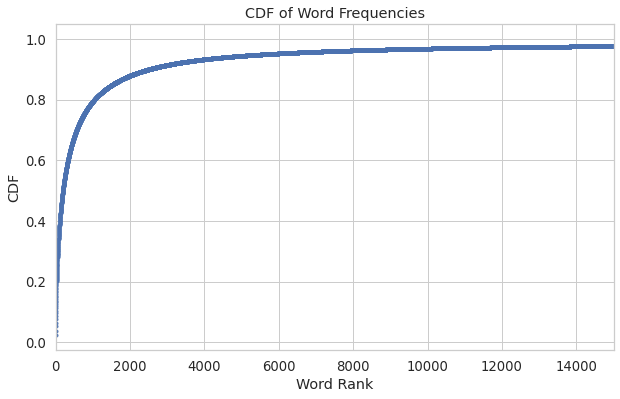

In [51]:
# Convert the word counts to pandas dataframe for visualization
word_counts_ordered_pd = word_counts_ordered.toPandas()

# 2. Compute the cumulative sum of the word frequencies
word_counts_ordered_pd['cumulative_freq'] = word_counts_ordered_pd['count'].cumsum()
word_counts_ordered_pd['cumulative_freq'] /= word_counts_ordered_pd['count'].sum()  # normalize to get the CDF

# 3. Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(word_counts_ordered_pd['cumulative_freq'], marker='.', linestyle='none')
plt.xlabel('Word Rank')
plt.xlim(0, 15000)
plt.ylabel('CDF')
plt.title('CDF of Word Frequencies')
plt.grid(True)
plt.show()


In [52]:
# Compute total word occurrences
total_word_occurrences = word_counts_ordered.agg({"count": "sum"}).collect()[0][0]

# Compute occurrences of top N words
N = 15000
top_N_word_occurrences = word_counts_ordered.limit(N).agg({"count": "sum"}).collect()[0][0]

# Compute the coverage
coverage = (top_N_word_occurrences / total_word_occurrences) * 100

print("Total word occurrences:", total_word_occurrences)
print(f"Occurrences of top {N} words:", top_N_word_occurrences)
print(f"Coverage of top {N} words: {coverage:.2f}%")

Total word occurrences: 4169309
Occurrences of top 15000 words: 4071637
Coverage of top 15000 words: 97.66%


Looking at the last codes, the CDF plot shows that the 15000 words is above 0.9. In addition the to the next code which tells that it covers 97.59%. Thus, a range of vocabulary will be set to N(15000) tokens (based on train set), and them filter the reviews to have tokens, which are in the range of (N). 

In [53]:
from pyspark.sql.functions import explode, count, desc, udf
from pyspark.sql.types import ArrayType, StringType
# Gets the top N tokens
N = 15000
top_N_tokens = word_counts_ordered.limit(N).select("words").rdd.flatMap(lambda x: x).collect()

# Broadcasting the top tokens list for efficient filtering
top_tokens_broadcast = spark.sparkContext.broadcast(set(top_N_tokens))

# Defines a filtering function that retains only those tokens present in our broadcasted top tokens set
def filter_native(tokens):
    return [t for t in tokens if t in top_tokens_broadcast.value]

# Defining UDF for our function
filter_udf = udf(filter_native, ArrayType(StringType()))

# Apply the UDF to the tokenized column in all three datasets:
df_train = df_train.withColumn("filtered_tokens", filter_udf(df_train["tokens_no_stopwords"]))
df_val = df_val.withColumn("filtered_tokens", filter_udf(df_val["tokens_no_stopwords"]))
df_test = df_test.withColumn("filtered_tokens", filter_udf(df_test["tokens_no_stopwords"]))

In [54]:
distinct_token_count = (df_train
                        .select(explode(col("filtered_tokens")).alias("word"))
                        .distinct()
                        .count())

print(f"Total distinct tokens in the dataset: {distinct_token_count}")

Total distinct tokens in the dataset: 15000


- According to the last line of code the filter function was a success by indicating that the total number of distinct tokens are 15,000, way below than the original number 155,981.

### 4. Feature Engineering (Word2Vec and Padding)

In this stage feature engineering steps will be applied to the sets.

- Lemmatization will be applied to handle words for example that are in the past, or with ing, but it has the same representation as the verb or noun.

In [56]:
# Loading spaCy model for Lemmatization.
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Creating a function for lemmatization, also using UDF.
@udf(ArrayType(StringType()))
def lemmatize_udf(tokens):
    # Convert list of tokens to single string.
    doc = nlp(" ".join(tokens))
    
    # Return list of lemmatized tokens.
    return [token.lemma_ for token in doc]

# Apply the UDF.
# Apply the UDF to all three datasets.
df_train = df_train.withColumn("lemmatized_tokens", lemmatize_udf(X_train["filtered_tokens"]))
df_val = df_val.withColumn("lemmatized_tokens", lemmatize_udf(X_val["filtered_tokens"]))
df_test = df_test.withColumn("lemmatized_tokens", lemmatize_udf(X_test["filtered_tokens"]))

In [57]:
X_train.select("filtered_tokens", "lemmatized_tokens").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_tokens                                                                                                                                                                                                                                                                                                         |lemmatized_tokens                                                       

- The previous code shows that the lemmatization was a success, words such as loved became love, turned is also turn.

Thus, next it will transform into vectors and the chosen tool is the Word2Vec, with the size of 100 and a minimum count of 5 (it has to pop up at leat 5 times). The Word2Vec model will follow three steps, first will set its configurations, second model will ve trained on the train set, and third will be applied (transform) on all three sets.

In [58]:
# Step 1: Define the Word2Vec model.
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="lemmatized_tokens", outputCol="Review_Vec")

# Step 2: Train the Word2Vec model on the training set.
model = word2Vec.fit(df_train)

In [59]:
# Step 3: Use the trained model to transform all datasets.
df_train_trans = model.transform(df_train)
df_val_trans = model.transform(df_val)
df_test_trans = model.transform(df_test)

- After the vectorizing stage, the following stage is the padding, but first the maximum legth of vectors has to be defined. 

In [73]:
df_train_trans.columns

NameError: name 'df_train_trans' is not defined

In [64]:
# Creating a funtion .
def vector_length(vector):
    return len(vector)

length_udf = udf(vector_length, IntegerType())

df_train_trans = df_train_trans.withColumn("sequence_length", length_udf(col("lemmatized_tokens")))

In [65]:
from pyspark.sql.functions import count, col, max as max_

# Calculate mean and standard deviation
df_train_trans.describe("sequence_length").show()

# Compute maximum sequence length
max_length = df_train_trans.agg(max_("sequence_length")).collect()[0][0]
print(f"Maximum Sequence Length: {max_length}")


+-------+------------------+
|summary|   sequence_length|
+-------+------------------+
|  count|            159577|
|   mean|26.055640850498506|
| stddev|18.117172673643704|
|    min|                 0|
|    max|               467|
+-------+------------------+



Maximum Sequence Length: 467


- The maximum length of  token to be used in the padding stage. However it was noticed in previous steps that the train data is very imbalanced, almost 94% of the set is composed by positives and negatives represents under 3%. Thus, oversampling the negatives (it will double) and neutrals (increase by 50%) and the positives will be undersampled by 25%. 

In [ ]:
# Extract as DataFrames, not Columns
X_train = df_train.select(["filtered_tokens"])
y_train = df_train.select(["label"])

X_val = df_val.select(["filtered_tokens"])
y_val = df_val.select(["label"])

X_test = df_test.select(["filtered_tokens"])
y_test = df_test.select(["label"])

In [66]:
# Separate out different classes from the training dataset
positives = X_train_trans.filter(col("label") == 'positive')
negatives = X_train_trans.filter(col("label") == 'negative')
neutrals = X_train_trans.filter(col("label") == 'neutral')

# Define oversampling factors
negative_oversample_factor = 2.0  # Double the negative samples
neutral_oversample_factor = 1.5   # 1.5 times the neutral samples

oversampled_negatives = negatives.sample(withReplacement=True, fraction=negative_oversample_factor)
oversampled_neutrals = neutrals.sample(withReplacement=True, fraction=neutral_oversample_factor)

# Undersample the majority class
undersample_factor = 0.25  # Reducing by 25%
undersampled_positives = positives.sample(withReplacement=False, fraction=undersample_factor)

# Combine the samples back
bal_X_train = undersampled_positives.unionAll(oversampled_negatives).unionAll(oversampled_neutrals)

# Calculate class weights for the balanced dataset
total_count = bal_X_train.count()
positive_weight = total_count / undersampled_positives.count()
negative_weight = total_count / (negatives.count() * negative_oversample_factor)
neutral_weight = total_count / (neutrals.count() * neutral_oversample_factor)

# Normalize weights
normalizing_factor = positive_weight + negative_weight + neutral_weight
positive_weight /= normalizing_factor
negative_weight /= normalizing_factor
neutral_weight /= normalizing_factor

class_weights = {
    'positive': positive_weight,
    'negative': negative_weight,
    'neutral': neutral_weight}

In [69]:
# Count instances for each class
positives = bal_X_train.filter(col("label") == 'positive').count()
negatives = bal_X_train.filter(col("label") == 'negative').count()
neutrals = bal_X_train.filter(col("label") == 'neutral').count()

total_count = positives + negatives + neutrals

# Calculate proportions for each class
positive_ratio = (positives / total_count) * 100
negative_ratio = (negatives / total_count) * 100
neutral_ratio = (neutrals / total_count) * 100

print(f"Rating Class Positives (4-5): {positive_ratio:.2f}%")
print(f"Rating Class Negatives (1-2): {negative_ratio:.2f}%")
print(f"Rating Class Neutral (3): {neutral_ratio:.2f}%")


AnalysisException: cannot resolve 'label' given input columns: [Review_Vec, filtered_tokens, lemmatized_tokens, sequence_length];
'Filter ('label = positive)
+- Union false, false
   :- Sample 0.0, 0.25, false, 4631377941153410876
   :  +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, sequence_length#2399]
   :     +- Filter (label#153 = positive)
   :        +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(lemmatized_tokens#2198) AS sequence_length#2399, label#153]
   :           +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(Review_Vec#2232) AS sequence_length#2260, label#153]
   :              +- Project [filtered_tokens#2128, lemmatized_tokens#2198, UDF(lemmatized_tokens#2198) AS Review_Vec#2232, label#153]
   :                 +- Project [filtered_tokens#2128, lemmatize_udf(filtered_tokens#2128) AS lemmatized_tokens#2198, label#153]
   :                    +- Project [filtered_tokens#2128, label#153]
   :                       +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, tokens_no_stopwords#1927, filter_native(tokens_no_stopwords#1927) AS filtered_tokens#2128]
   :                          +- Filter (size(tokens_no_stopwords#1927, true) > 0)
   :                             +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, UDF(filt_tokens#1857) AS tokens_no_stopwords#1927]
   :                                +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, <lambda>(tokens#1781) AS filt_tokens#1857]
   :                                   +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, UDF(Review_no_punct2#1060) AS tokens#1781]
   :                                      +- Filter UDF(label#153, rand(42))
   :                                         +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, regexp_replace(Review_no_punct#1038, [
], , 1) AS Review_no_punct2#1060]
   :                                            +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, rev_char_length#899, regexp_replace(Review_lower#756, [^a-zA-Z\s], , 1) AS Review_no_punct#1038]
   :                                               +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, Review_lower#756, length(Review_lower#756) AS rev_char_length#899]
   :                                                  +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, label#153, lower(Review#5) AS Review_lower#756]
   :                                                     +- Filter NOT (Rating#4 = 0)
   :                                                        +- Filter UDF(label#153, rand(42))
   :                                                           +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5, CASE WHEN rating#4 IN (0,1,2) THEN negative WHEN (rating#4 = 3) THEN neutral ELSE positive END AS label#153]
   :                                                              +- Project [ReviewId#0, RecipeId#1, AuthorId#2, AuthorName#3, Rating#4, Review#5]
   :                                                                 +- Relation [ReviewId#0,RecipeId#1,AuthorId#2,AuthorName#3,Rating#4,Review#5,DateSubmitted#6,DateModified#7] parquet
   :- Project [filtered_tokens#2128 AS filtered_tokens#2545, lemmatized_tokens#2198 AS lemmatized_tokens#2546, Review_Vec#2232 AS Review_Vec#2547, sequence_length#2399 AS sequence_length#2548]
   :  +- Sample 0.0, 2.0, true, -3909861199592578861
   :     +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, sequence_length#2399]
   :        +- Filter (label#153 = negative)
   :           +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(lemmatized_tokens#2198) AS sequence_length#2399, label#153]
   :              +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(Review_Vec#2232) AS sequence_length#2260, label#153]
   :                 +- Project [filtered_tokens#2128, lemmatized_tokens#2198, UDF(lemmatized_tokens#2198) AS Review_Vec#2232, label#153]
   :                    +- Project [filtered_tokens#2128, lemmatize_udf(filtered_tokens#2128) AS lemmatized_tokens#2198, label#153]
   :                       +- Project [filtered_tokens#2128, label#153]
   :                          +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, tokens_no_stopwords#1927, filter_native(tokens_no_stopwords#1927) AS filtered_tokens#2128]
   :                             +- Filter (size(tokens_no_stopwords#1927, true) > 0)
   :                                +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, UDF(filt_tokens#1857) AS tokens_no_stopwords#1927]
   :                                   +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, <lambda>(tokens#1781) AS filt_tokens#1857]
   :                                      +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, UDF(Review_no_punct2#1060) AS tokens#1781]
   :                                         +- Filter UDF(label#153, rand(42))
   :                                            +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, regexp_replace(Review_no_punct#1038, [
], , 1) AS Review_no_punct2#1060]
   :                                               +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, rev_char_length#899, regexp_replace(Review_lower#756, [^a-zA-Z\s], , 1) AS Review_no_punct#1038]
   :                                                  +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, Review_lower#756, length(Review_lower#756) AS rev_char_length#899]
   :                                                     +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, label#153, lower(Review#2542) AS Review_lower#756]
   :                                                        +- Filter NOT (Rating#2541 = 0)
   :                                                           +- Filter UDF(label#153, rand(42))
   :                                                              +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542, CASE WHEN rating#2541 IN (0,1,2) THEN negative WHEN (rating#2541 = 3) THEN neutral ELSE positive END AS label#153]
   :                                                                 +- Project [ReviewId#2537, RecipeId#2538, AuthorId#2539, AuthorName#2540, Rating#2541, Review#2542]
   :                                                                    +- Relation [ReviewId#2537,RecipeId#2538,AuthorId#2539,AuthorName#2540,Rating#2541,Review#2542,DateSubmitted#2543,DateModified#2544] parquet
   +- Project [filtered_tokens#2128 AS filtered_tokens#2573, lemmatized_tokens#2198 AS lemmatized_tokens#2574, Review_Vec#2232 AS Review_Vec#2575, sequence_length#2399 AS sequence_length#2576]
      +- Sample 0.0, 1.5, true, 7453967907175433174
         +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, sequence_length#2399]
            +- Filter (label#153 = neutral)
               +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(lemmatized_tokens#2198) AS sequence_length#2399, label#153]
                  +- Project [filtered_tokens#2128, lemmatized_tokens#2198, Review_Vec#2232, vector_length(Review_Vec#2232) AS sequence_length#2260, label#153]
                     +- Project [filtered_tokens#2128, lemmatized_tokens#2198, UDF(lemmatized_tokens#2198) AS Review_Vec#2232, label#153]
                        +- Project [filtered_tokens#2128, lemmatize_udf(filtered_tokens#2128) AS lemmatized_tokens#2198, label#153]
                           +- Project [filtered_tokens#2128, label#153]
                              +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, tokens_no_stopwords#1927, filter_native(tokens_no_stopwords#1927) AS filtered_tokens#2128]
                                 +- Filter (size(tokens_no_stopwords#1927, true) > 0)
                                    +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, filt_tokens#1857, UDF(filt_tokens#1857) AS tokens_no_stopwords#1927]
                                       +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, tokens#1781, <lambda>(tokens#1781) AS filt_tokens#1857]
                                          +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, Review_no_punct2#1060, UDF(Review_no_punct2#1060) AS tokens#1781]
                                             +- Filter UDF(label#153, rand(42))
                                                +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, Review_no_punct#1038, regexp_replace(Review_no_punct#1038, [
], , 1) AS Review_no_punct2#1060]
                                                   +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, rev_char_length#899, regexp_replace(Review_lower#756, [^a-zA-Z\s], , 1) AS Review_no_punct#1038]
                                                      +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, Review_lower#756, length(Review_lower#756) AS rev_char_length#899]
                                                         +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, label#153, lower(Review#2570) AS Review_lower#756]
                                                            +- Filter NOT (Rating#2569 = 0)
                                                               +- Filter UDF(label#153, rand(42))
                                                                  +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570, CASE WHEN rating#2569 IN (0,1,2) THEN negative WHEN (rating#2569 = 3) THEN neutral ELSE positive END AS label#153]
                                                                     +- Project [ReviewId#2565, RecipeId#2566, AuthorId#2567, AuthorName#2568, Rating#2569, Review#2570]
                                                                        +- Relation [ReviewId#2565,RecipeId#2566,AuthorId#2567,AuthorName#2568,Rating#2569,Review#2570,DateSubmitted#2571,DateModified#2572] parquet


As observed in previous cells, the gap ratio between the classes are large. Therefore, a few techniques will be combined to reduce the imbalaced between positive (93.63%), negative (2.58%) and neutral (3.79).<br><br> 
The first technique is the oversampling, increasing the size of the negative and neutral sample. It is worthy mentioning that this may cause overfiting, because it will increase by copying the data that already has.<b> WRITE THE AMOUNT OF THE INCREASE (DOUBLE TRIPLE...), NEED TO EXPERIMENT BASED ON RESULTS OF THE MODEL.</b><br><br>
The second is to undersample the positive side (93.63%) and it will be reduced by <b> SAME APPLY HERE AS THE PREVIOUS ONE.</b> One of the downfalls is the lost of information by reducing the sample.<br><br>
The last one is to apply class weights, <b>CHECK IF ITS GONNA BE SURE</b>, because even after the over and undersampling the imbalance is still present but not as large as the original.

# ADD PADDING

In [68]:
from keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(reviews_list)

# `sequences` is a list of lists, where each inner list is a sequence of word indices.
padded_sequences = pad_sequences(sequences, padding='pre')


2023-10-05 21:42:28.911637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 21:42:30.583684: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-05 21:42:30.583740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-05 21:42:30.589719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 21:42:31.079916: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 21:42:31.092624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

NameError: name 'sequences' is not defined